# Can we identify a stable "best subset"?

### Prepare workspace

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))

# Change path to match location of PPC datasets
# Datasets are available from the Harvey lab
import ppc_data_loader
ppc_data_loader.path = '/home/mrule/Workspace2/PPC_data/'

# Import PPC libraries
from ppc_data_loader   import *
from ppc_trial         import *

Data  location is /home/mrule/Workspace2/PPC_data
Cache location is /home/mrule/Desktop/Github/Loback_et_al/Rule/cache
Loading nlab namespace


In [2]:
%matplotlib inline

from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE])
matplotlib.rcParams['figure.dpi']=150
figure() # Check that Matplotlib really did load (bug workaround?)

print('Matplotlib configured')

Matplotlib configured


<Figure size 900x600 with 0 Axes>

## Data loading example

In [3]:
animals    = get_subject_ids()
animal     = choice(animals)
cues       = [ppc_trial.Trial.CUE_LEFT,ppc_trial.Trial.CUE_RIGHT]
CUE        = choice(cues)
PREV       = choice(cues)
cname      = ['left','right'][CUE]
pname      = ['left','right'][PREV]
sessions   = get_session_ids(animal)
session    = choice(sessions)
units      = good_units_index(animal,session)
NNEURONS   = len(units)
FS         = get_FS(animal,session)

print('Using animal' ,animal )
print('Using trials with cued direction',cname)
print('Using trials with previous direction',pname)
print('Using session',session)

#### Sanity check that physical units seem correct
intrials = get_intrial(animal,session)
print('\n%02d%% of timepoints are within a trial'%(100*mean(intrials)))
print('y dimension is %s meters'%np.max(get_y(animal,session)[intrials]))
print('x dimension is %s meters'%np.max(get_x(animal,session)[intrials]))
print('peak dx from position is',\
      np.max(abs(diff(get_x(animal,session)))[intrials[:-1]])*FS)
print('peak dx from velocity is',\
      np.max(abs(get_dx(animal,session))[intrials]))

hdfdata = get_data(animal,session)
printmatHDF5(hdfdata)
for i,label in enumerate(getHDF(hdfdata,'session_obj/timeSeries/virmen/labels')):
    print(i,label)

Using animal 2
Using trials with cued direction right
Using trials with previous direction left
Using session 15

84% of timepoints are within a trial
y dimension is 4.580330147041574 meters
x dimension is 0.15015015015015015 meters
peak dx from position is 0.6609443630075884
peak dx from velocity is 0.5647359213075638
 session_obj:
 :  | confidenceLabel | 1264 x 1 | float64 | 'numpy.ndarray | 
 :  | deltaDays       | 1 x 23   | float64 | 'numpy.ndarray | 
 :  | numConditions   | 1 x 24   | float64 | 'numpy.ndarray | 
 :  | sessionList     | 1 x 23   | object  | 'numpy.ndarray | 
 :  | sessionNumber   | 1 x 1    | float64 | 15.0           | 
 : analysis:
 : : glm:
 : : :  | cv_object           | 1 x 1264    | object  | 'numpy.ndarray | 
 : : :  | filterMatrix        | 11357 x 144 | float64 | 'numpy.ndarray | 
 : : :  | filterMatrixIDs     | 144 x 1     | object  | 'numpy.ndarray | 
 : : :  | foldID              | 11357 x 1   | float64 | 'numpy.ndarray | 
 : : :  | frame_idx           |

## Helper functions

In [18]:
MAXSAMPLES = 400  # Remove overly-long trials
NXVAL      = 10   # No. crossvalidation blocks
JITTER     = 25   # No. frames tolerance btwn trial end marker & reward

def get_trials(signal,animal,session,MAXSAMPLES=MAXSAMPLES,JITTER=JITTER,meanzero=True,dozscore=False):
    # Find edges of all CORRECT trials
    all_trials = get_basic_trial_info(animal,session,pad_edges=False,JITTER=JITTER)
    use_trials = [t for t in all_trials if t.correct and t.nsample<MAXSAMPLES]
    starts     = [t.istart for t in use_trials]
    stops      = [t.istop  for t in use_trials]
    trials     = [signal[a:b,...] for (a,b) in zip(starts,stops)]
    if meanzero: # mean-center each trial separately
        trials = list(map(lambda x:zeromean(x,axis=0),trials))
    if dozscore:
        trials = list(map(lambda x:zscore(x,axis=0),trials))
    return trials

def get_neural_signals_for_training(animal,session,units=None,verbose=False):
    units = good_units_index(animal,session) if units is None else np.int32(units)
    dFF   = get_dFF(animal,session,units)
    ydata = get_trials(dFF,animal,session,dozscore=True)
    return ydata

# Greedy optimization of cross-validated fits

For linear models, the L2 error under cross validation has a closed-form expression:

$$
\begin{aligned}
\hat M &= \Sigma_{aa}^{-1} \Sigma_{ab}\\
\epsilon &= \hat M^\top \left( \Sigma_{aa\text{ test}} \hat M - 2 \Sigma_{ab\text{ test}} \right)
\end{aligned}
$$

# Stability of greedy sorts over time

In [30]:
kininfo = {
    0:{'name':'X position'    ,'units':'m'  ,'get':get_x},
    1:{'name':'Y position'    ,'units':'m'  ,'get':get_y},
    2:{'name':'X velocity'    ,'units':'m/s','get':get_dx},
    3:{'name':'Y velocity'    ,'units':'m/s','get':get_dy},
    4:{'name':'Head direction','units':'°'  ,'get':get_theta}
}

def get_greedy_sort(animal,session,variable,units,NXVAL=10):
    
    
    ydatas = get_neural_signals_for_training(animal,session,units,verbose=True)
    get    = kininfo[variable]['get']
    xdatas = get_trials(get(animal,session),animal,session)
    
    indecies = partition_trials_for_crossvalidation(xdatas,NXVAL,shuffle=True)
    xtrials = [array(xdatas)[i] for i in indecies]
    ytrials = [array(ydatas)[i] for i in indecies]
    # Testing sets
    tsB = [cat(x) for x in xtrials]
    tsA = [cat(y) for y in ytrials]
    # Training sets
    alls = set(arange(NXVAL))
    trB = [cat([cat(xtrials[xi]) for xi in sorted(list(alls-{i}))]) for i in range(len(sessions))]
    trA = [cat([cat(ytrials[yi]) for yi in sorted(list(alls-{i}))]) for i in range(len(sessions))]
    
    N = ytrials[0][0].shape[1]
    r   = 1e-15*eye(N)

    # Covariances and cross-covariances
    sAtr  = [(a.T@ a)/a.shape[0]+r for a     in trA         ] # Train ind.
    sAts  = [(a.T@ a)/a.shape[0]+r for a     in tsA         ] # Test ind.
    sABtr = [(a.T@ b)/a.shape[0]   for (a,b) in zip(trA,trB)] # Train cross
    sABts = [(a.T@ b)/a.shape[0]   for (a,b) in zip(tsA,tsB)] # Test cross
    sBts  = [(b.T@ b)/b.shape[0]   for b     in tsB         ] # Test dep.

    # Ascending greedy
    unused = set(arange(N))
    used   = set()
    e0     = sum(sBts) # Baseline error rate (variance of testing data)
    tic(0)
    order = []
    delta = []
    for i in range(N):
        check = array(sorted(list(unused)))
        er    = zeros(len(unused))
        for j,ch in enumerate(check):
            u = array(sorted(list(used)+[ch]))
            error = e0
            for aa,ab,aav,abv in zip(sAtr,sABtr,sAts,sABts):
                w = solve(aa[u,:][:,u],ab[u])
                error += w.T @ (aav[:,u] @ w - 2 * abv)[u]
            er[j] = error/NXVAL
        # Update set
        best   = check[argmin(er)]
        minerr = np.min(er)
        unused.remove(best)
        used.add(best)
        order.append(best)
        delta.append(minerr)
        print('%3d|%3d:%5.3f (%4dms)'%(i,best,minerr,toc(0)[1]),end='\n' if i%4==3 else ' '*5)
        tic(0)

    print('\nOrder is',' '.join(map(str,order)))
    return order,delta

In [31]:
animal   = 4
sessions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

#animal   = 3
#sessions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# y position
variable = 1

units    = get_units_in_common(animal,sessions)[0]
print('Using %d units'%len(units))

results = [get_greedy_sort(animal,session,variable,units) for session in sessions]
orders,deltas = zip(*results)

Using 126 units
  0| 13:1.497 ( 159ms)       1|120:1.197 ( 131ms)       2|125:1.044 ( 133ms)       3| 70:0.938 ( 127ms)
  4| 20:0.849 ( 130ms)       5| 71:0.767 ( 125ms)       6|  8:0.719 ( 132ms)       7|115:0.679 ( 128ms)
  8| 60:0.646 ( 129ms)       9| 85:0.620 ( 321ms)      10| 49:0.604 ( 499ms)      11| 95:0.589 ( 345ms)
 12| 51:0.576 ( 339ms)      13| 42:0.566 ( 449ms)      14| 57:0.556 ( 860ms)      15| 90:0.548 ( 956ms)
 16| 37:0.540 ( 472ms)      17| 72:0.533 ( 548ms)      18|  3:0.527 ( 426ms)      19| 38:0.520 ( 434ms)
 20|  0:0.514 ( 463ms)      21| 61:0.508 ( 538ms)      22| 46:0.503 ( 500ms)      23| 94:0.499 (1103ms)
 24| 89:0.494 ( 748ms)      25| 75:0.491 ( 669ms)      26| 81:0.487 ( 477ms)      27| 87:0.484 ( 811ms)
 28| 84:0.480 ( 560ms)      29|105:0.477 ( 641ms)      30| 59:0.475 ( 890ms)      31| 93:0.472 ( 670ms)
 32| 30:0.469 ( 634ms)      33| 39:0.467 ( 594ms)      34| 65:0.464 ( 608ms)      35| 25:0.462 ( 597ms)
 36|119:0.460 ( 599ms)      37| 63:0.458 ( 664ms

 32| 45:0.514 ( 642ms)      33| 69:0.511 ( 572ms)      34| 72:0.508 ( 571ms)      35|112:0.506 ( 582ms)
 36| 53:0.503 ( 635ms)      37| 67:0.500 ( 620ms)      38| 65:0.498 ( 643ms)      39| 12:0.496 ( 662ms)
 40| 73:0.493 ( 728ms)      41|  3:0.491 ( 629ms)      42| 90:0.490 ( 677ms)      43| 79:0.488 ( 608ms)
 44| 61:0.486 ( 686ms)      45| 15:0.484 ( 672ms)      46| 50:0.483 ( 693ms)      47| 99:0.481 ( 717ms)
 48| 16:0.480 ( 729ms)      49| 64:0.478 ( 669ms)      50| 85:0.476 ( 739ms)      51| 40:0.475 ( 707ms)
 52|102:0.474 ( 751ms)      53| 22:0.472 ( 738ms)      54| 81:0.471 ( 754ms)      55| 54:0.469 ( 782ms)
 56| 78:0.468 ( 748ms)      57|101:0.467 ( 816ms)      58|107:0.466 ( 780ms)      59| 14:0.465 ( 804ms)
 60|105:0.464 ( 828ms)      61| 21:0.463 ( 851ms)      62| 59:0.462 ( 888ms)      63| 86:0.461 ( 827ms)
 64| 24:0.461 ( 881ms)      65| 55:0.460 ( 780ms)      66| 34:0.459 ( 806ms)      67| 56:0.459 ( 843ms)
 68| 77:0.458 ( 814ms)      69|119:0.458 ( 865ms)      70|  7:0.

 64| 37:0.333 ( 949ms)      65| 31:0.333 ( 824ms)      66| 45:0.333 ( 865ms)      67| 79:0.333 ( 839ms)
 68| 82:0.333 ( 855ms)      69| 22:0.333 ( 920ms)      70| 67:0.333 ( 856ms)      71| 96:0.333 (1006ms)
 72| 69:0.332 ( 868ms)      73| 93:0.332 ( 935ms)      74| 33:0.332 ( 844ms)      75|116:0.332 ( 856ms)
 76|109:0.332 ( 913ms)      77|106:0.332 ( 866ms)      78| 66:0.332 ( 868ms)      79| 16:0.332 ( 873ms)
 80| 43:0.332 ( 840ms)      81| 23:0.332 ( 747ms)      82|104:0.332 ( 752ms)      83| 63:0.332 ( 742ms)
 84|123:0.332 ( 711ms)      85| 98:0.333 ( 734ms)      86| 75:0.333 ( 688ms)      87|121:0.333 ( 681ms)
 88| 38:0.333 ( 696ms)      89| 14:0.333 ( 722ms)      90|  2:0.333 ( 666ms)      91|103:0.333 ( 751ms)
 92|  4:0.333 ( 700ms)      93|111:0.333 ( 682ms)      94| 55:0.333 ( 684ms)      95| 32:0.333 ( 694ms)
 96| 52:0.334 ( 651ms)      97| 36:0.334 ( 617ms)      98| 19:0.334 ( 620ms)      99| 50:0.334 ( 595ms)
100| 58:0.334 ( 599ms)     101|  5:0.334 ( 582ms)     102|105:0.

 96|100:0.331 ( 639ms)      97| 74:0.331 ( 628ms)      98|109:0.332 ( 573ms)      99|124:0.332 ( 599ms)
100| 77:0.332 ( 550ms)     101| 31:0.332 ( 549ms)     102| 95:0.332 ( 533ms)     103| 58:0.332 ( 508ms)
104|118:0.333 ( 491ms)     105| 16:0.333 ( 497ms)     106| 64:0.333 ( 608ms)     107| 12:0.333 ( 439ms)
108| 28:0.333 ( 448ms)     109| 56:0.334 ( 449ms)     110| 98:0.334 ( 376ms)     111| 51:0.334 ( 399ms)
112|  8:0.334 ( 370ms)     113|  9:0.335 ( 357ms)     114| 94:0.335 ( 291ms)     115| 97:0.335 ( 303ms)
116| 89:0.335 ( 263ms)     117| 22:0.336 ( 284ms)     118| 43:0.336 ( 190ms)     119|  0:0.336 ( 213ms)
120| 21:0.336 ( 164ms)     121| 17:0.337 ( 167ms)     122| 62:0.337 ( 112ms)     123| 10:0.337 (  97ms)
124|116:0.338 (  71ms)     125| 19:0.338 (  26ms)     
Order is 20 71 70 84 42 120 125 115 3 49 33 102 87 111 88 13 76 79 38 80 112 103 106 39 45 18 83 122 6 107 50 47 105 40 101 72 78 59 57 7 53 81 63 65 114 90 86 110 104 54 113 36 85 14 91 35 11 26 93 73 27 2 48 61 24 2

  0|114:1.572 ( 158ms)       1| 20:1.032 ( 126ms)       2|112:0.850 ( 128ms)       3| 67:0.723 ( 126ms)
  4| 95:0.671 ( 129ms)       5|115:0.628 ( 130ms)       6| 71:0.598 ( 129ms)       7| 87:0.577 ( 127ms)
  8| 66:0.555 ( 133ms)       9|125:0.532 ( 327ms)      10| 92:0.515 ( 297ms)      11|100:0.502 ( 320ms)
 12| 93:0.490 ( 314ms)      13| 42:0.480 ( 345ms)      14| 33:0.470 ( 342ms)      15| 80:0.459 ( 361ms)
 16| 49:0.451 ( 381ms)      17| 57:0.445 ( 379ms)      18| 83:0.438 ( 349ms)      19| 63:0.431 ( 370ms)
 20| 62:0.425 ( 402ms)      21| 70:0.421 ( 460ms)      22| 36:0.415 ( 431ms)      23| 90:0.411 ( 464ms)
 24| 14:0.406 ( 488ms)      25|120:0.403 ( 497ms)      26| 25:0.399 ( 513ms)      27| 46:0.395 ( 484ms)
 28| 17:0.392 ( 522ms)      29| 50:0.389 ( 587ms)      30| 43:0.387 ( 572ms)      31|119:0.384 ( 601ms)
 32| 45:0.382 ( 602ms)      33|103:0.379 ( 540ms)      34|102:0.377 ( 569ms)      35| 32:0.375 ( 611ms)
 36| 61:0.373 ( 643ms)      37|  7:0.371 ( 645ms)      38| 29:0.

 32| 90:0.360 ( 647ms)      33| 36:0.358 ( 584ms)      34|101:0.356 ( 626ms)      35|105:0.354 ( 604ms)
 36| 51:0.353 ( 614ms)      37| 38:0.351 ( 670ms)      38|118:0.350 ( 651ms)      39| 50:0.348 ( 695ms)
 40| 55:0.347 ( 718ms)      41| 52:0.346 ( 604ms)      42| 91:0.345 ( 615ms)      43| 60:0.343 ( 701ms)
 44| 76:0.342 ( 679ms)      45|106:0.341 ( 722ms)      46| 14:0.340 ( 736ms)      47| 35:0.339 ( 726ms)
 48|122:0.339 ( 740ms)      49| 75:0.338 ( 695ms)      50| 61:0.337 ( 704ms)      51| 31:0.336 ( 722ms)
 52| 68:0.335 ( 728ms)      53| 53:0.335 ( 747ms)      54| 95:0.334 ( 752ms)      55| 89:0.334 ( 747ms)
 56| 41:0.333 ( 780ms)      57| 11:0.333 ( 790ms)      58| 25:0.332 ( 809ms)      59|121:0.332 ( 799ms)
 60| 40:0.331 ( 851ms)      61|110:0.331 ( 872ms)      62| 67:0.331 ( 850ms)      63| 43:0.330 ( 813ms)
 64| 24:0.330 ( 893ms)      65| 79:0.330 ( 874ms)      66| 47:0.330 ( 828ms)      67|107:0.329 ( 820ms)
 68| 94:0.329 ( 819ms)      69|109:0.329 ( 903ms)      70| 44:0.

Text(0.5, 0, 'Neuron # (from least to most important)')

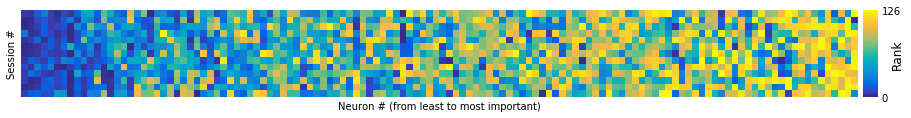

In [39]:
orders = np.int32(orders)
K = len(orders[0])
a = np.float32([argsort(o) for o in orders])
p = argsort(np.std(a,axis=0)+np.mean(a,axis=0))

figure(figsize=(15,5))
imshow(a[:,p])
noxyaxes()
good_colorbar(vmin=0,vmax=a.shape[1],title='Rank')

ylabel('Session #')
xlabel('Neuron # (from least to most important)')

For both mice 3 (10 days, 104 neurons) and 4 (13 days, 126 neurons), 6% of neurons are consistently in the top 50% for all sessions. No neurons were consistently in the top 10% for all days. 

For mouse 4 (126 neurons, 13 days), 6% of neurons were in th top 50% for all sessions, and 

# Greedy search a concatenated dataset

A "best" subset does exist, but is hard to identify from single-day recordings. 

In [48]:
animal   = 3
sessions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
units    = get_units_in_common(animal,sessions)[0]
variable = 1
print('Using %d units'%len(units))

ydatas = [get_neural_signals_for_training(animal,s,units,verbose=True) for s in sessions]
get    = kininfo[variable]['get']
xdatas = [get_trials(get(animal,s),animal,s) for s in sessions]

ydatas = sum(ydatas)
xdatas = sum(xdatas)

indecies = partition_trials_for_crossvalidation(xdatas,10,shuffle=True)
xtrials = [array(xdatas)[i] for i in indecies]
ytrials = [array(ydatas)[i] for i in indecies]

# Testing sets
tsB = [cat(x) for x in xtrials]
tsA = [cat(y) for y in ytrials]

# Training sets
alls = set(arange(NXVAL))
trB = [cat([cat(xtrials[xi]) for xi in sorted(list(alls-{i}))]) for i in range(len(sessions))]
trA = [cat([cat(ytrials[yi]) for yi in sorted(list(alls-{i}))]) for i in range(len(sessions))]

N = ytrials[0][0].shape[1]
r = 1e-15*eye(N)

# Covariances and cross-covariances
sAtr  = [(a.T@ a)/a.shape[0]+r for a     in trA         ] # Train ind.
sAts  = [(a.T@ a)/a.shape[0]+r for a     in tsA         ] # Test ind.
sABtr = [(a.T@ b)/a.shape[0]   for (a,b) in zip(trA,trB)] # Train cross
sABts = [(a.T@ b)/a.shape[0]   for (a,b) in zip(tsA,tsB)] # Test cross
sBts  = [(b.T@ b)/b.shape[0]   for b     in tsB         ] # Test dep.

# Ascending greedy
unused = set(arange(N))
used   = set()
e0     = sum(sBts) # Baseline error rate (variance of testing data)
tic(0)
order = []
delta = []
for i in range(N):
    check = array(sorted(list(unused)))
    er    = zeros(len(unused))
    for j,ch in enumerate(check):
        u = array(sorted(list(used)+[ch]))
        error = e0
        for aa,ab,aav,abv in zip(sAtr,sABtr,sAts,sABts):
            w = solve(aa[u,:][:,u],ab[u])
            error += w.T @ (aav[:,u] @ w - 2 * abv)[u]
        er[j] = error/NXVAL
    # Update set
    best   = check[argmin(er)]
    minerr = np.min(er)
    unused.remove(best)
    used.add(best)
    order.append(best)
    delta.append(minerr)
    print('%3d|%3d:%5.3f (%4dms)'%(i,best,minerr,toc(0)[1]),end='\n' if i%4==3 else ' '*5)
    tic(0)

print('\nOrder is',' '.join(map(str,order)))

Using 104 units
  0|  9:2.126 ( 138ms)       1| 23:1.780 ( 104ms)       2| 62:1.547 ( 110ms)       3| 93:1.363 ( 112ms)
  4| 50:1.251 ( 114ms)       5|  5:1.161 ( 104ms)       6| 81:1.065 ( 106ms)       7| 76:1.004 ( 105ms)
  8| 38:0.949 ( 106ms)       9| 15:0.907 ( 286ms)      10| 66:0.866 ( 246ms)      11|  4:0.826 ( 252ms)
 12| 64:0.803 ( 250ms)      13| 31:0.782 ( 282ms)      14|  1:0.763 ( 290ms)      15| 32:0.745 ( 306ms)
 16| 84:0.730 ( 346ms)      17| 78:0.717 ( 309ms)      18| 33:0.706 ( 298ms)      19| 44:0.696 ( 314ms)
 20| 85:0.688 ( 351ms)      21| 34:0.680 ( 341ms)      22| 57:0.673 ( 351ms)      23| 10:0.666 ( 359ms)
 24| 26:0.660 ( 395ms)      25| 74:0.654 ( 387ms)      26| 17:0.648 ( 364ms)      27| 88:0.644 ( 379ms)
 28| 43:0.640 ( 399ms)      29| 90:0.636 ( 429ms)      30| 86:0.632 ( 436ms)      31| 89:0.629 ( 424ms)
 32| 52:0.626 ( 437ms)      33| 87:0.623 ( 428ms)      34| 16:0.620 ( 402ms)      35| 14:0.617 ( 448ms)
 36| 73:0.614 ( 449ms)      37|101:0.611 ( 478ms